In [1]:
# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [2]:
# Cell 2: Load Dataset from Google Drive
import gdown
import os

# Google Drive file ID
file_id = "1AfIYtJcG2NUS_DQoLKoHAw21seVFrjKB"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the file
print("Downloading dataset from Google Drive...")
output_path = "marks_dataset.xlsx"
gdown.download(url, output_path, quiet=False)

# Verify file exists
if os.path.exists(output_path):
    print(f"✓ Dataset downloaded successfully: {output_path}")
    file_size = os.path.getsize(output_path) / 1024  # Size in KB
    print(f"File size: {file_size:.2f} KB")
else:
    print("✗ Failed to download dataset")

Downloading...
From: https://drive.google.com/uc?id=1AfIYtJcG2NUS_DQoLKoHAw21seVFrjKB
To: /content/marks_dataset.xlsx
100%|██████████| 45.2k/45.2k [00:00<00:00, 49.7MB/s]

✓ Dataset downloaded successfully: marks_dataset.xlsx
File size: 44.18 KB


In [3]:
# Cell 3: Load All Excel Sheets
excel_file = pd.ExcelFile(output_path)

print(f"Total sheets in Excel file: {len(excel_file.sheet_names)}")
print(f"Sheet names: {excel_file.sheet_names}\n")

# Load all sheets into a dictionary
all_sheets = {}
for sheet_name in excel_file.sheet_names:
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    all_sheets[sheet_name] = df
    print(f"Sheet '{sheet_name}':")
    print(f"  - Shape: {df.shape}")
    print(f"  - Columns: {df.columns.tolist()[:5]}...")  # Show first 5 columns
    print()

print(f"✓ Loaded {len(all_sheets)} sheets successfully!")

Total sheets in Excel file: 6
Sheet names: ['1', '2', '3', '4', '5', '6']

Sheet '1':
  - Shape: (37, 21)
  - Columns: ['Unnamed: 0', 'As:1', 'As:2', 'As:3', 'As:4']...

Sheet '2':
  - Shape: (31, 21)
  - Columns: ['Unnamed: 0', 'As:1', 'As:2', 'As:3', 'As:4']...

Sheet '3':
  - Shape: (47, 21)
  - Columns: ['Unnamed: 0', 'As:1', 'As:2', 'As:3', 'As:4']...

Sheet '4':
  - Shape: (49, 19)
  - Columns: ['Unnamed: 0', 'As:1', 'As:2', 'As:3', 'As:4']...

Sheet '5':
  - Shape: (54, 25)
  - Columns: ['Unnamed: 0', 'As:1', 'As:2', 'As:3', 'As:4']...

Sheet '6':
  - Shape: (54, 25)
  - Columns: ['Unnamed: 0', 'As:1', 'As:2', 'As:3', 'As:4']...

✓ Loaded 6 sheets successfully!


In [4]:
# Cell 4: Initial Data Exploration
print("=" * 80)
print("INITIAL DATA EXPLORATION")
print("=" * 80)

for sheet_name, df in all_sheets.items():
    print(f"\n{'='*60}")
    print(f"SHEET: {sheet_name}")
    print(f"{'='*60}")

    print(f"\nShape: {df.shape} (Rows: {df.shape[0]}, Columns: {df.shape[1]})")

    print("\nFirst 3 rows:")
    print(df.head(3))

    print("\nColumn names:")
    print(df.columns.tolist())

    print("\nData types:")
    print(df.dtypes.value_counts())

    print("\nMissing values:")
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
    else:
        print("No missing values detected")

    print("\nBasic statistics:")
    print(df.describe().T)

INITIAL DATA EXPLORATION

SHEET: 1

Shape: (37, 21) (Rows: 37, Columns: 21)

First 3 rows:
   Unnamed: 0   As:1  As:2  As:3  As:4   As:5  As:6  Qz:1  Qz:2  Qz:3  ...  \
0  Weightage:    3.0   3.0   3.0   3.0    3.0   3.0   2.0   2.0   2.0  ...   
1       Total  130.0  70.0  90.0  50.0  120.0  90.0   5.0  15.0  10.0  ...   
2        Sr.#    NaN   NaN   NaN   NaN    NaN   NaN   NaN   NaN   NaN  ...   

   Qz:5  Qz:6  Qz:7  Qz:8  S-I:1   S-I  S-II:1  S-II  Final:1  Final  
0   2.0   2.0   2.0   2.0   15.0  15.0    15.0  15.0     45.0   45.0  
1  10.0   5.0  12.0   2.0   40.0   NaN    40.0   NaN    100.0    NaN  
2   NaN   NaN   NaN   NaN    NaN   NaN     NaN   NaN      NaN    NaN  

[3 rows x 21 columns]

Column names:
['Unnamed: 0', 'As:1', 'As:2', 'As:3', 'As:4', 'As:5', 'As:6', 'Qz:1', 'Qz:2', 'Qz:3', 'Qz:4', 'Qz:5', 'Qz:6', 'Qz:7', 'Qz:8', 'S-I:1', 'S-I', 'S-II:1', 'S-II', 'Final:1', 'Final']

Data types:
float64    20
object      1
Name: count, dtype: int64

Missing values:
As:1     

In [5]:
# Cell 5: Data Preprocessing Functions

def identify_column_types(df):
    """Identify assignment, quiz, midterm, and final columns"""
    cols = df.columns.tolist()

    # Remove non-score columns
    score_cols = [col for col in cols if col not in ['Sr.#', 'Weightage:', 'Total']]

    assignments = [col for col in score_cols if 'As' in str(col) or 'Assignment' in str(col)]
    quizzes = [col for col in score_cols if 'Qz' in str(col) or 'Quiz' in str(col)]
    midterms = [col for col in score_cols if 'S-I' in str(col) or 'Mid' in str(col) or 'Midterm' in str(col)]
    finals = [col for col in score_cols if 'Final' in str(col)]

    return {
        'assignments': assignments,
        'quizzes': quizzes,
        'midterms': midterms,
        'finals': finals,
        'all_scores': score_cols
    }


def clean_dataframe(df):
    """Clean and preprocess a single dataframe"""
    df_clean = df.copy()

    # Remove rows that are not student data (like Weightage, Total)
    if 'Sr.#' in df_clean.columns:
        # Keep only rows where Sr.# is numeric
        df_clean = df_clean[pd.to_numeric(df_clean['Sr.#'], errors='coerce').notna()]
        df_clean['Sr.#'] = df_clean['Sr.#'].astype(int)

    # Identify column types
    col_types = identify_column_types(df_clean)

    # Convert all score columns to numeric, replacing non-numeric with NaN
    for col in col_types['all_scores']:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Fill missing values with 0 (assuming missing means no submission/score)
    df_clean[col_types['all_scores']] = df_clean[col_types['all_scores']].fillna(0)

    return df_clean, col_types


def standardize_column_names(df, col_types, sheet_idx):
    """Standardize column names across sheets"""
    df_std = df.copy()

    rename_map = {}

    # Standardize assignments
    for i, col in enumerate(col_types['assignments'], 1):
        rename_map[col] = f'Assignment_{i}'

    # Standardize quizzes
    for i, col in enumerate(col_types['quizzes'], 1):
        rename_map[col] = f'Quiz_{i}'

    # Standardize midterms
    for i, col in enumerate(col_types['midterms'], 1):
        rename_map[col] = f'Midterm_{i}'

    # Standardize finals
    for i, col in enumerate(col_types['finals'], 1):
        rename_map[col] = f'Final_{i}'

    df_std = df_std.rename(columns=rename_map)

    return df_std


print("✓ Preprocessing functions defined successfully!")

✓ Preprocessing functions defined successfully!


In [6]:
# Cell 5: Data Preprocessing Functions

def identify_column_types(df):
    """Identify assignment, quiz, midterm, and final columns"""
    cols = df.columns.tolist()

    # Remove non-score columns
    score_cols = [col for col in cols if col not in ['Sr.#', 'Weightage:', 'Total']]

    assignments = [col for col in score_cols if 'As' in str(col) or 'Assignment' in str(col)]
    quizzes = [col for col in score_cols if 'Qz' in str(col) or 'Quiz' in str(col)]
    midterms = [col for col in score_cols if 'S-I' in str(col) or 'Mid' in str(col) or 'Midterm' in str(col)]
    finals = [col for col in score_cols if 'Final' in str(col)]

    return {
        'assignments': assignments,
        'quizzes': quizzes,
        'midterms': midterms,
        'finals': finals,
        'all_scores': score_cols
    }


def clean_dataframe(df):
    """Clean and preprocess a single dataframe"""
    df_clean = df.copy()

    # Remove rows that are not student data (like Weightage, Total)
    if 'Sr.#' in df_clean.columns:
        # Keep only rows where Sr.# is numeric
        df_clean = df_clean[pd.to_numeric(df_clean['Sr.#'], errors='coerce').notna()]
        df_clean['Sr.#'] = df_clean['Sr.#'].astype(int)

    # Identify column types
    col_types = identify_column_types(df_clean)

    # Convert all score columns to numeric, replacing non-numeric with NaN
    for col in col_types['all_scores']:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # Fill missing values with 0 (assuming missing means no submission/score)
    df_clean[col_types['all_scores']] = df_clean[col_types['all_scores']].fillna(0)

    return df_clean, col_types


def standardize_column_names(df, col_types, sheet_idx):
    """Standardize column names across sheets"""
    df_std = df.copy()

    rename_map = {}

    # Standardize assignments
    for i, col in enumerate(col_types['assignments'], 1):
        rename_map[col] = f'Assignment_{i}'

    # Standardize quizzes
    for i, col in enumerate(col_types['quizzes'], 1):
        rename_map[col] = f'Quiz_{i}'

    # Standardize midterms
    for i, col in enumerate(col_types['midterms'], 1):
        rename_map[col] = f'Midterm_{i}'

    # Standardize finals
    for i, col in enumerate(col_types['finals'], 1):
        rename_map[col] = f'Final_{i}'

    df_std = df_std.rename(columns=rename_map)

    return df_std


print("✓ Preprocessing functions defined successfully!")

✓ Preprocessing functions defined successfully!


In [7]:
# Cell 6: Apply Preprocessing to All Sheets
print("=" * 80)
print("PREPROCESSING ALL SHEETS")
print("=" * 80)

cleaned_sheets = {}
col_types_all = {}

for idx, (sheet_name, df) in enumerate(all_sheets.items(), 1):
    print(f"\nProcessing sheet: {sheet_name}")

    # Clean the dataframe
    df_clean, col_types = clean_dataframe(df)

    # Standardize column names
    df_std = standardize_column_names(df_clean, col_types, idx)

    # Add sheet identifier
    df_std['Sheet'] = sheet_name

    cleaned_sheets[sheet_name] = df_std
    col_types_all[sheet_name] = col_types

    print(f"  Original shape: {df.shape}")
    print(f"  Cleaned shape: {df_std.shape}")
    print(f"  Columns: {df_std.columns.tolist()}")
    print(f"  Assignments: {len([c for c in df_std.columns if 'Assignment' in c])}")
    print(f"  Quizzes: {len([c for c in df_std.columns if 'Quiz' in c])}")
    print(f"  Midterms: {len([c for c in df_std.columns if 'Midterm' in c])}")
    print(f"  Finals: {len([c for c in df_std.columns if 'Final' in c])}")

print(f"\n✓ Preprocessing completed for {len(cleaned_sheets)} sheets!")

PREPROCESSING ALL SHEETS

Processing sheet: 1
  Original shape: (37, 21)
  Cleaned shape: (37, 22)
  Columns: ['Unnamed: 0', 'Assignment_1', 'Assignment_2', 'Assignment_3', 'Assignment_4', 'Assignment_5', 'Assignment_6', 'Quiz_1', 'Quiz_2', 'Quiz_3', 'Quiz_4', 'Quiz_5', 'Quiz_6', 'Quiz_7', 'Quiz_8', 'Midterm_1', 'Midterm_2', 'Midterm_3', 'Midterm_4', 'Final_1', 'Final_2', 'Sheet']
  Assignments: 6
  Quizzes: 8
  Midterms: 4
  Finals: 2

Processing sheet: 2
  Original shape: (31, 21)
  Cleaned shape: (31, 22)
  Columns: ['Unnamed: 0', 'Assignment_1', 'Assignment_2', 'Assignment_3', 'Assignment_4', 'Assignment_5', 'Assignment_6', 'Quiz_1', 'Quiz_2', 'Quiz_3', 'Quiz_4', 'Quiz_5', 'Quiz_6', 'Quiz_7', 'Quiz_8', 'Midterm_1', 'Midterm_2', 'Midterm_3', 'Midterm_4', 'Final_1', 'Final_2', 'Sheet']
  Assignments: 6
  Quizzes: 8
  Midterms: 4
  Finals: 2

Processing sheet: 3
  Original shape: (47, 21)
  Cleaned shape: (47, 22)
  Columns: ['Unnamed: 0', 'Assignment_1', 'Assignment_2', 'Assignment_3

In [8]:
# Cell 7: Combine All Sheets into One Dataset

# Get all unique columns across all sheets
all_columns = set()
for df in cleaned_sheets.values():
    all_columns.update(df.columns)

# Sort columns logically
assignment_cols = sorted([col for col in all_columns if 'Assignment' in col])
quiz_cols = sorted([col for col in all_columns if 'Quiz' in col])
midterm_cols = sorted([col for col in all_columns if 'Midterm' in col])
final_cols = sorted([col for col in all_columns if 'Final' in col])
other_cols = ['Sr.#', 'Sheet']

ordered_columns = other_cols + assignment_cols + quiz_cols + midterm_cols + final_cols

# Combine all sheets
combined_data = []
for sheet_name, df in cleaned_sheets.items():
    # Ensure all columns exist
    for col in ordered_columns:
        if col not in df.columns:
            df[col] = 0 if col not in other_cols else None

    combined_data.append(df[ordered_columns])

# Concatenate all dataframes
df_combined = pd.concat(combined_data, ignore_index=True)

# Reset student IDs to be unique across all sheets
df_combined['Student_ID'] = range(1, len(df_combined) + 1)

print("=" * 80)
print("COMBINED DATASET")
print("=" * 80)
print(f"\nTotal students: {len(df_combined)}")
print(f"Total features: {len(df_combined.columns)}")
print(f"\nShape: {df_combined.shape}")
print(f"\nColumns: {df_combined.columns.tolist()}")
print(f"\nFirst few rows:")
print(df_combined.head())
print(f"\nData types:")
print(df_combined.dtypes.value_counts())
print(f"\nMissing values:")
print(df_combined.isnull().sum().sum())

print("\n✓ All sheets combined successfully!")

COMBINED DATASET

Total students: 272
Total features: 31

Shape: (272, 31)

Columns: ['Sr.#', 'Sheet', 'Assignment_1', 'Assignment_2', 'Assignment_3', 'Assignment_4', 'Assignment_5', 'Assignment_6', 'Quiz_1', 'Quiz_2', 'Quiz_3', 'Quiz_4', 'Quiz_5', 'Quiz_6', 'Quiz_7', 'Quiz_8', 'Midterm_1', 'Midterm_2', 'Midterm_3', 'Midterm_4', 'Midterm_5', 'Midterm_6', 'Midterm_7', 'Midterm_8', 'Final_1', 'Final_2', 'Final_3', 'Final_4', 'Final_5', 'Final_6', 'Student_ID']

First few rows:
   Sr.# Sheet  Assignment_1  Assignment_2  Assignment_3  Assignment_4  \
0  None     1           3.0           3.0           3.0           3.0   
1  None     1         130.0          70.0          90.0          50.0   
2  None     1           0.0           0.0           0.0           0.0   
3  None     1          80.5          60.5          73.5          40.5   
4  None     1          72.5          68.0          39.0          35.0   

   Assignment_5  Assignment_6  Quiz_1  Quiz_2  ...  Midterm_6  Midterm_7  \
0    

In [9]:
# Cell 8: Feature Engineering

df_features = df_combined.copy()

# Get column categories
assignment_cols = [col for col in df_features.columns if 'Assignment' in col]
quiz_cols = [col for col in df_features.columns if 'Quiz' in col]
midterm_cols = [col for col in df_features.columns if 'Midterm' in col]
final_cols = [col for col in df_features.columns if 'Final' in col]

print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Create aggregate features
print("\nCreating aggregate features...")

# Assignment aggregates
df_features['Assignment_Mean'] = df_features[assignment_cols].mean(axis=1)
df_features['Assignment_Max'] = df_features[assignment_cols].max(axis=1)
df_features['Assignment_Min'] = df_features[assignment_cols].min(axis=1)
df_features['Assignment_Std'] = df_features[assignment_cols].std(axis=1).fillna(0)
df_features['Assignment_Sum'] = df_features[assignment_cols].sum(axis=1)

# Quiz aggregates
df_features['Quiz_Mean'] = df_features[quiz_cols].mean(axis=1)
df_features['Quiz_Max'] = df_features[quiz_cols].max(axis=1)
df_features['Quiz_Min'] = df_features[quiz_cols].min(axis=1)
df_features['Quiz_Std'] = df_features[quiz_cols].std(axis=1).fillna(0)
df_features['Quiz_Sum'] = df_features[quiz_cols].sum(axis=1)

# Combined performance metrics
df_features['Overall_Mean'] = df_features[assignment_cols + quiz_cols].mean(axis=1)
df_features['Overall_Std'] = df_features[assignment_cols + quiz_cols].std(axis=1).fillna(0)

# Consistency metrics (coefficient of variation)
df_features['Assignment_CV'] = (df_features['Assignment_Std'] / (df_features['Assignment_Mean'] + 0.01))
df_features['Quiz_CV'] = (df_features['Quiz_Std'] / (df_features['Quiz_Mean'] + 0.01))

print(f"✓ Created {len([c for c in df_features.columns if c not in df_combined.columns])} new features")
print(f"\nNew features: {[c for c in df_features.columns if c not in df_combined.columns]}")

print(f"\nFinal dataset shape: {df_features.shape}")
print(f"\nSample of engineered features:")
print(df_features[['Assignment_Mean', 'Quiz_Mean', 'Overall_Mean']].head())

FEATURE ENGINEERING

Creating aggregate features...
✓ Created 14 new features

New features: ['Assignment_Mean', 'Assignment_Max', 'Assignment_Min', 'Assignment_Std', 'Assignment_Sum', 'Quiz_Mean', 'Quiz_Max', 'Quiz_Min', 'Quiz_Std', 'Quiz_Sum', 'Overall_Mean', 'Overall_Std', 'Assignment_CV', 'Quiz_CV']

Final dataset shape: (272, 45)

Sample of engineered features:
   Assignment_Mean  Quiz_Mean  Overall_Mean
0         3.000000     2.0000      2.428571
1        91.666667     8.6250     44.214286
2         0.000000     0.0000      0.000000
3        64.083333     4.0000     29.750000
4        61.000000     5.4375     29.250000


EXPLORATORY DATA ANALYSIS - SCORE DISTRIBUTIONS


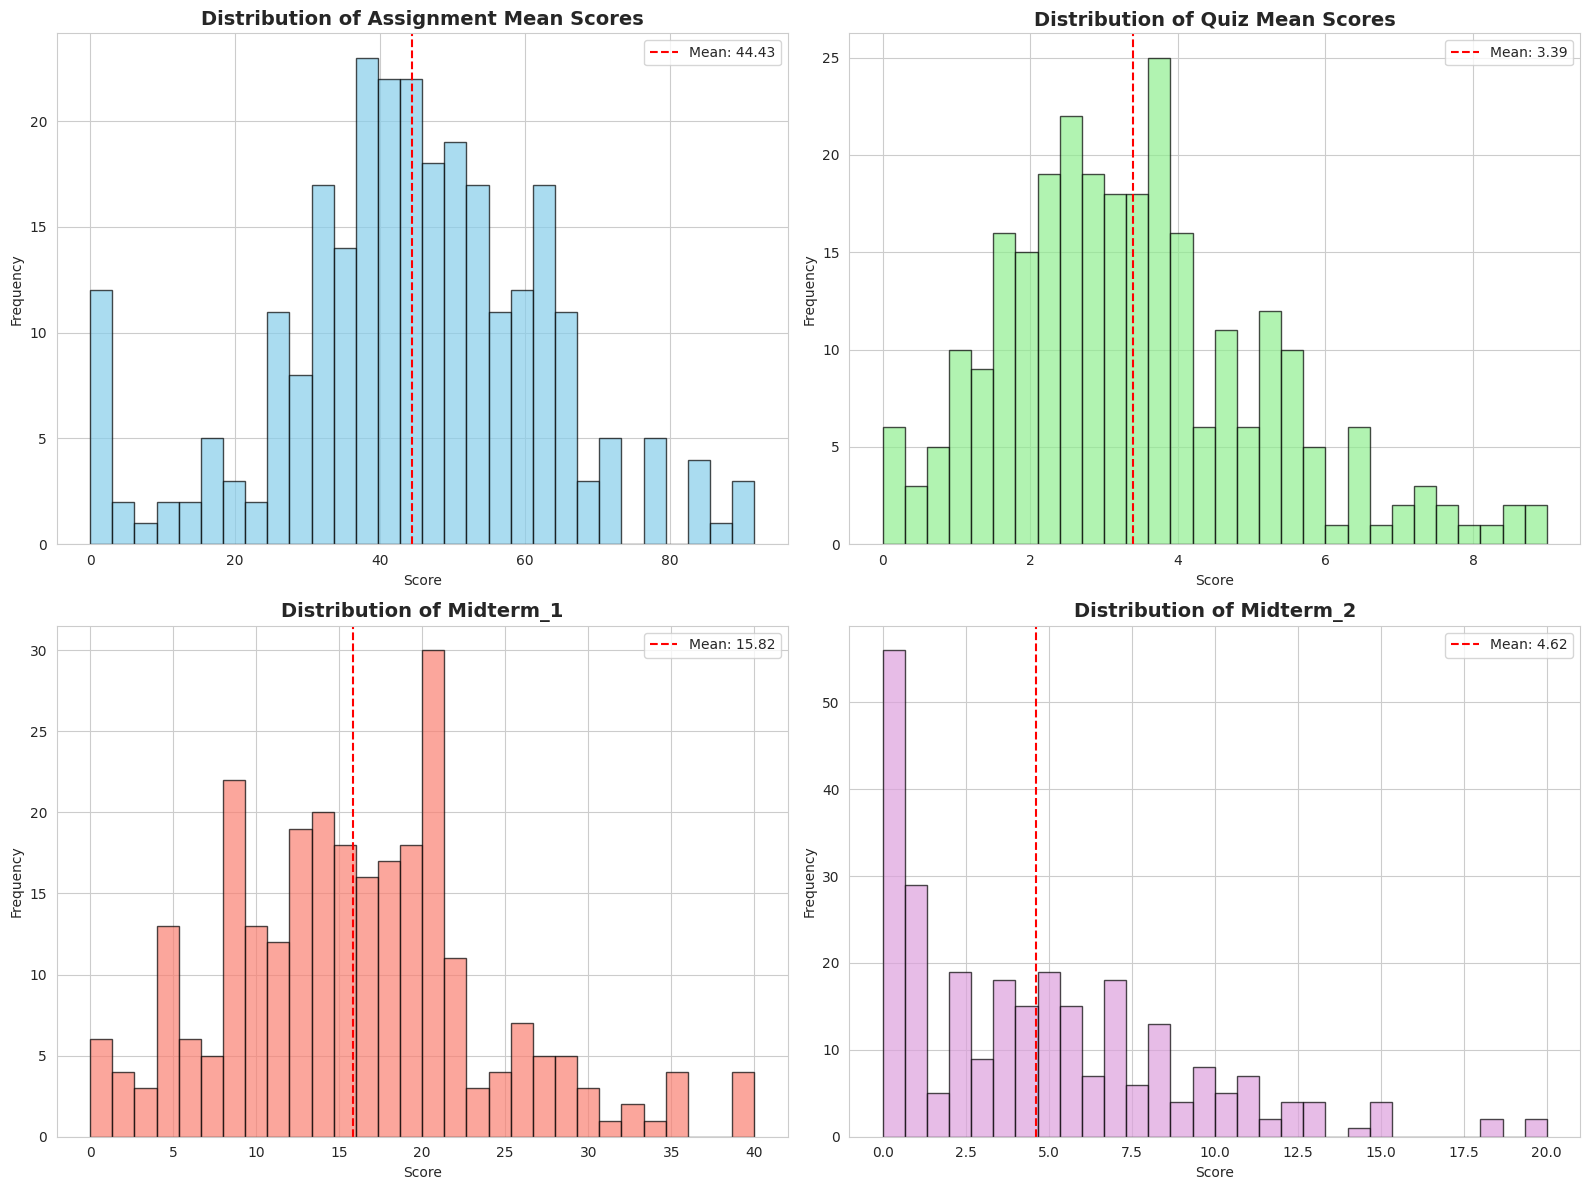


✓ Distribution plots generated!


In [10]:
# Cell 9: Exploratory Data Analysis - Distributions

print("=" * 80)
print("EXPLORATORY DATA ANALYSIS - SCORE DISTRIBUTIONS")
print("=" * 80)

# Plot distributions of assignments, quizzes, and exams
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Assignment Mean Distribution
axes[0, 0].hist(df_features['Assignment_Mean'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Assignment Mean Scores', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_features['Assignment_Mean'].mean(), color='red', linestyle='--',
                    label=f"Mean: {df_features['Assignment_Mean'].mean():.2f}")
axes[0, 0].legend()

# Quiz Mean Distribution
axes[0, 1].hist(df_features['Quiz_Mean'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Quiz Mean Scores', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df_features['Quiz_Mean'].mean(), color='red', linestyle='--',
                    label=f"Mean: {df_features['Quiz_Mean'].mean():.2f}")
axes[0, 1].legend()

# Midterm scores (if available)
if len(midterm_cols) >= 2:
    axes[1, 0].hist(df_features[midterm_cols[0]], bins=30, color='salmon', edgecolor='black', alpha=0.7)
    axes[1, 0].set_title(f'Distribution of {midterm_cols[0]}', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Score')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].axvline(df_features[midterm_cols[0]].mean(), color='red', linestyle='--',
                        label=f"Mean: {df_features[midterm_cols[0]].mean():.2f}")
    axes[1, 0].legend()

    axes[1, 1].hist(df_features[midterm_cols[1]], bins=30, color='plum', edgecolor='black', alpha=0.7)
    axes[1, 1].set_title(f'Distribution of {midterm_cols[1]}', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Score')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].axvline(df_features[midterm_cols[1]].mean(), color='red', linestyle='--',
                        label=f"Mean: {df_features[midterm_cols[1]].mean():.2f}")
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ Distribution plots generated!")

CORRELATION ANALYSIS


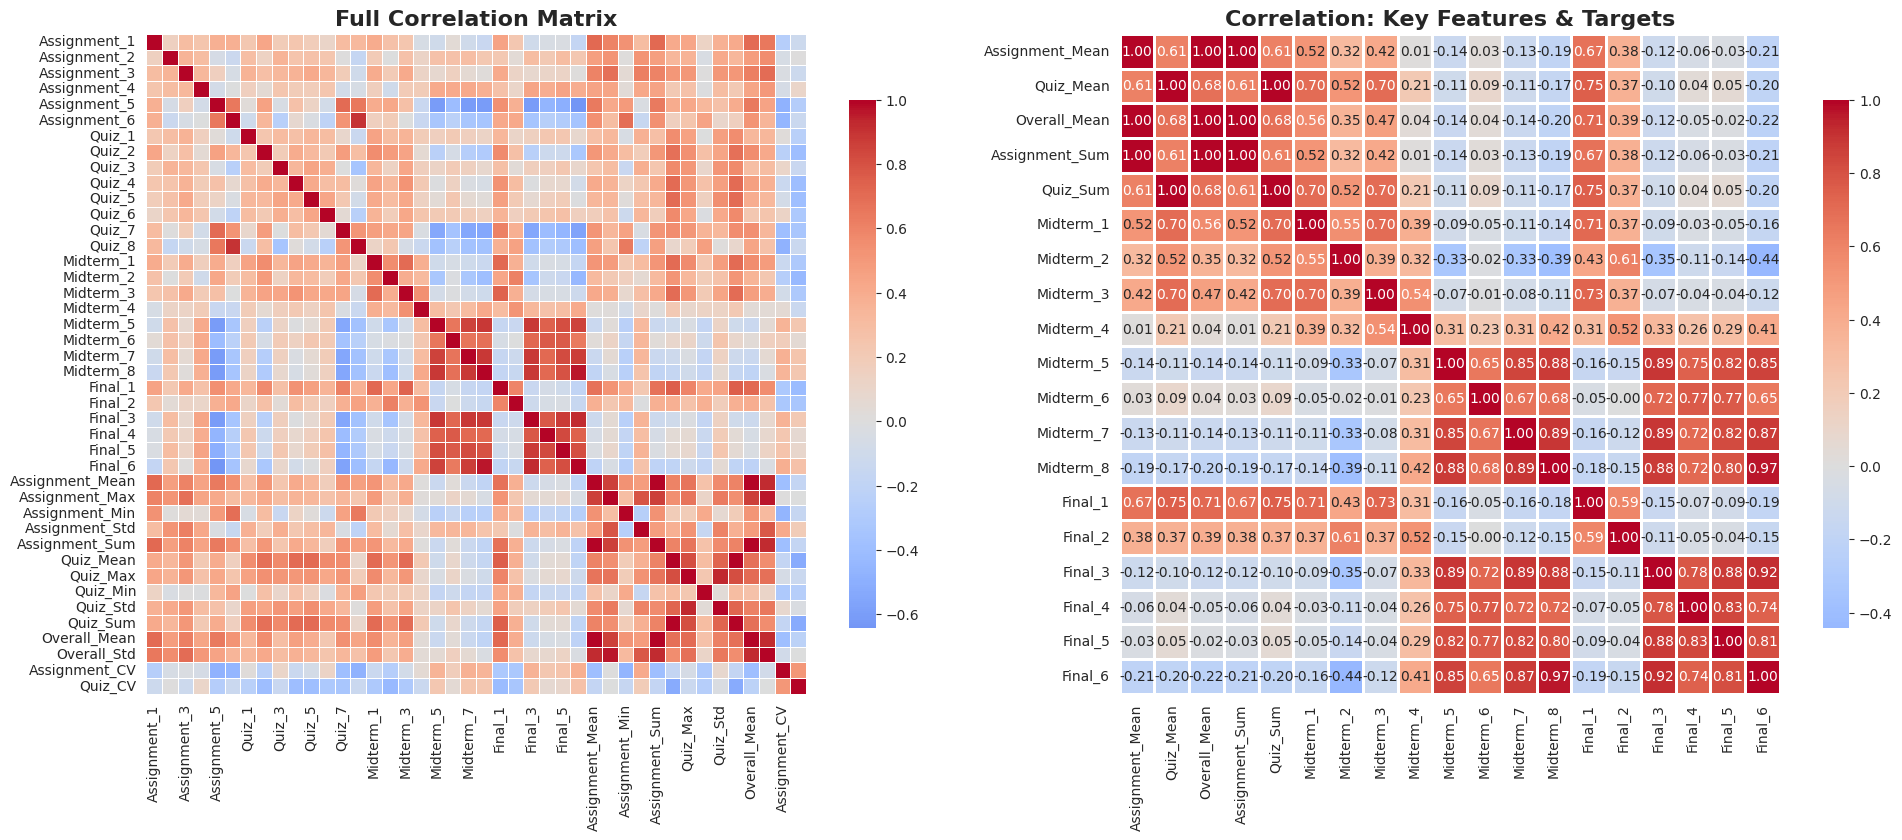


Top correlations with Midterm_1:
Midterm_1          1.000000
Final_1            0.711940
Quiz_Mean          0.700621
Quiz_Sum           0.700621
Midterm_3          0.700197
Quiz_Max           0.569188
Overall_Mean       0.561327
Quiz_2             0.560214
Midterm_2          0.554426
Assignment_Mean    0.517541
Name: Midterm_1, dtype: float64

Top correlations with Midterm_2:
Midterm_2       1.000000
Final_2         0.609896
Midterm_1       0.554426
Quiz_Mean       0.517207
Quiz_Sum        0.517207
Quiz_2          0.482794
Final_1         0.432001
Assignment_5    0.427873
Quiz_7          0.426730
Midterm_3       0.391526
Name: Midterm_2, dtype: float64

✓ Correlation analysis completed!


In [11]:
# Cell 10: Exploratory Data Analysis - Correlation Analysis

print("=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)

# Select numeric columns for correlation
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Sr.#', 'Student_ID']]

# Calculate correlation matrix
corr_matrix = df_features[numeric_cols].corr()

# Plot correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Full correlation heatmap (smaller font for many variables)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=axes[0])
axes[0].set_title('Full Correlation Matrix', fontsize=16, fontweight='bold')

# Focus on aggregate features and targets
focus_features = ['Assignment_Mean', 'Quiz_Mean', 'Overall_Mean',
                  'Assignment_Sum', 'Quiz_Sum'] + midterm_cols + final_cols
focus_features = [f for f in focus_features if f in df_features.columns]

corr_focus = df_features[focus_features].corr()
sns.heatmap(corr_focus, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Correlation: Key Features & Targets', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Print top correlations with targets
print("\nTop correlations with Midterm_1:")
if 'Midterm_1' in df_features.columns:
    mid1_corr = corr_matrix['Midterm_1'].sort_values(ascending=False)
    print(mid1_corr.head(10))

print("\nTop correlations with Midterm_2:")
if 'Midterm_2' in df_features.columns:
    mid2_corr = corr_matrix['Midterm_2'].sort_values(ascending=False)
    print(mid2_corr.head(10))

print("\n✓ Correlation analysis completed!")

BOX PLOTS - OUTLIER DETECTION


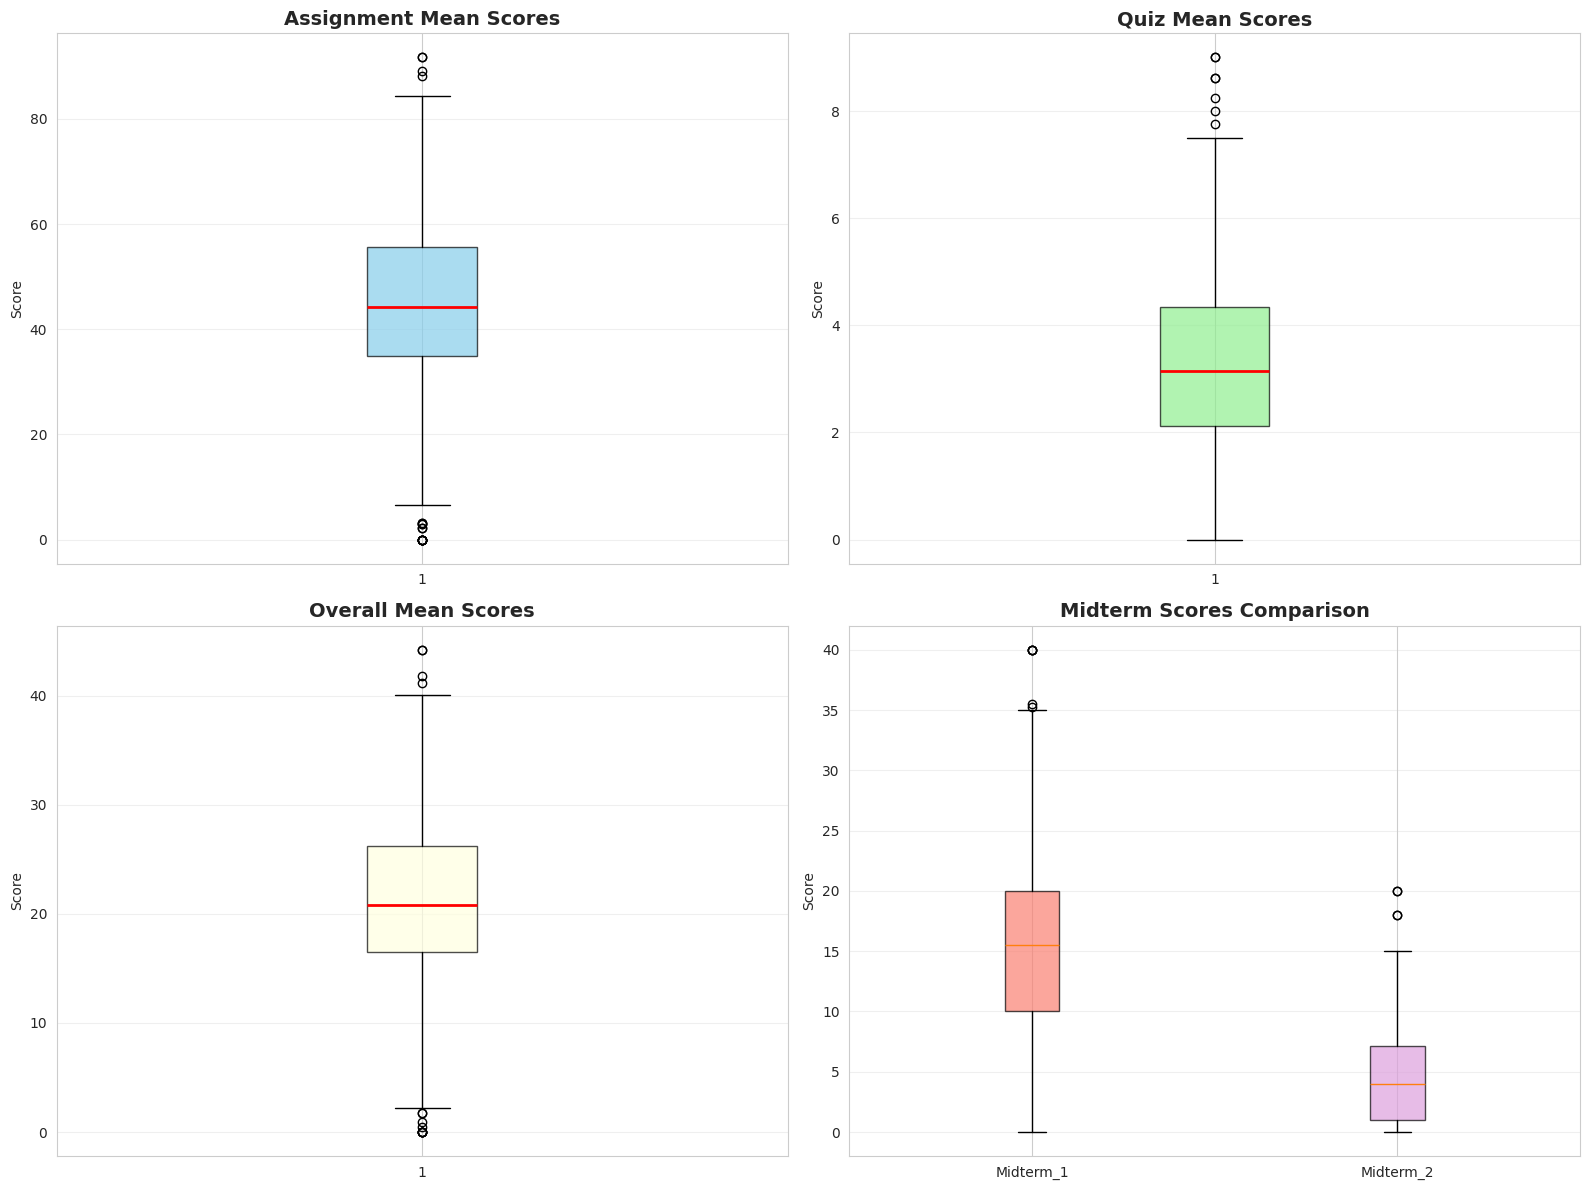


Outlier Analysis (IQR Method):

Assignment_Mean:
  Lower bound: 3.71, Upper bound: 86.71
  Number of outliers: 18 (6.62%)

Quiz_Mean:
  Lower bound: -1.20, Upper bound: 7.67
  Number of outliers: 7 (2.57%)

Overall_Mean:
  Lower bound: 1.89, Upper bound: 40.82
  Number of outliers: 14 (5.15%)

✓ Box plot analysis completed!


In [12]:
# Cell 11: EDA - Box Plots for Outlier Detection

print("=" * 80)
print("BOX PLOTS - OUTLIER DETECTION")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Aggregate features box plots
plot_data = [
    ('Assignment_Mean', 'Assignment Mean Scores', 'skyblue', axes[0, 0]),
    ('Quiz_Mean', 'Quiz Mean Scores', 'lightgreen', axes[0, 1]),
    ('Overall_Mean', 'Overall Mean Scores', 'lightyellow', axes[1, 0])
]

for feature, title, color, ax in plot_data:
    if feature in df_features.columns:
        ax.boxplot(df_features[feature].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor=color, alpha=0.7),
                   medianprops=dict(color='red', linewidth=2))
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_ylabel('Score')
        ax.grid(axis='y', alpha=0.3)

# Midterm scores comparison
if len(midterm_cols) >= 2:
    midterm_data = [df_features[col].dropna() for col in midterm_cols[:2]]
    bp = axes[1, 1].boxplot(midterm_data, labels=midterm_cols[:2], patch_artist=True)

    for patch, color in zip(bp['boxes'], ['salmon', 'plum']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    axes[1, 1].set_title('Midterm Scores Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Detect outliers using IQR method
print("\nOutlier Analysis (IQR Method):")
for feature in ['Assignment_Mean', 'Quiz_Mean', 'Overall_Mean']:
    if feature in df_features.columns:
        Q1 = df_features[feature].quantile(0.25)
        Q3 = df_features[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_features[(df_features[feature] < lower_bound) |
                               (df_features[feature] > upper_bound)]
        print(f"\n{feature}:")
        print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
        print(f"  Number of outliers: {len(outliers)} ({len(outliers)/len(df_features)*100:.2f}%)")

print("\n✓ Box plot analysis completed!")

In [13]:
# Cell 12: Prepare Data for Modeling (Avoiding Data Leakage)

print("=" * 80)
print("PREPARING DATA FOR MODELING")
print("=" * 80)

# Define features for each research question
# RQ1: Predict Midterm I (using only data available before Midterm I)
rq1_features = assignment_cols + quiz_cols + [
    'Assignment_Mean', 'Assignment_Max', 'Assignment_Min', 'Assignment_Std', 'Assignment_Sum',
    'Quiz_Mean', 'Quiz_Max', 'Quiz_Min', 'Quiz_Std', 'Quiz_Sum',
    'Overall_Mean', 'Overall_Std', 'Assignment_CV', 'Quiz_CV'
]
rq1_target = 'Midterm_1' if 'Midterm_1' in df_features.columns else midterm_cols[0]

# RQ2: Predict Midterm II (using data up to Midterm I, but NOT Midterm II)
rq2_features = rq1_features + [rq1_target]  # Include Midterm I as feature
rq2_target = 'Midterm_2' if 'Midterm_2' in df_features.columns else (midterm_cols[1] if len(midterm_cols) > 1 else None)

# RQ3: Predict Final (using all data except Final)
rq3_features = rq2_features + ([rq2_target] if rq2_target else [])
if len(final_cols) > 0:
    rq3_target = final_cols[0]
else:
    rq3_target = None

print("\nResearch Question 1: Predict Midterm I")
print(f"  Target: {rq1_target}")
print(f"  Features: {len(rq1_features)} features")
print(f"  Available data points: {df_features[rq1_target].notna().sum()}")

if rq2_target:
    print("\nResearch Question 2: Predict Midterm II")
    print(f"  Target: {rq2_target}")
    print(f"  Features: {len(rq2_features)} features (including Midterm I)")
    print(f"  Available data points: {df_features[rq2_target].notna().sum()}")

if rq3_target:
    print("\nResearch Question 3: Predict Final Exam")
    print(f"  Target: {rq3_target}")
    print(f"  Features: {len(rq3_features)} features (including both midterms)")
    print(f"  Available data points: {df_features[rq3_target].notna().sum()}")

# Remove rows with missing target values for each RQ
df_rq1 = df_features[df_features[rq1_target].notna()].copy()
if rq2_target:
    df_rq2 = df_features[df_features[rq2_target].notna()].copy()
if rq3_target:
    df_rq3 = df_features[df_features[rq3_target].notna()].copy()

print("\n✓ Data prepared for modeling with NO data leakage!")
print("  - RQ1: Only uses assignments and quizzes")
print("  - RQ2: Uses assignments, quizzes, and Midterm I")
print("  - RQ3: Uses all available data up to but not including Final")

PREPARING DATA FOR MODELING

Research Question 1: Predict Midterm I
  Target: Midterm_1
  Features: 28 features
  Available data points: 272

Research Question 2: Predict Midterm II
  Target: Midterm_2
  Features: 29 features (including Midterm I)
  Available data points: 272

Research Question 3: Predict Final Exam
  Target: Final_1
  Features: 30 features (including both midterms)
  Available data points: 272

✓ Data prepared for modeling with NO data leakage!
  - RQ1: Only uses assignments and quizzes
  - RQ2: Uses assignments, quizzes, and Midterm I
  - RQ3: Uses all available data up to but not including Final


In [14]:
# Cell 13: Train-Test Split (NO data leakage in preprocessing)

def prepare_train_test(df, features, target, test_size=0.2, random_state=42):
    """
    Prepare train-test split WITHOUT data leakage
    Scaling is fit ONLY on training data
    """
    # Extract features and target
    X = df[features].copy()
    y = df[target].copy()

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Fit scaler ONLY on training data (avoid data leakage!)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)  # Use fitted scaler on test

    # Convert back to DataFrame for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

    return X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler


print("=" * 80)
print("TRAIN-TEST SPLIT")
print("=" * 80)

# Prepare data for RQ1
X_train_rq1, X_test_rq1, y_train_rq1, y_test_rq1, X_train_rq1_scaled, X_test_rq1_scaled, scaler_rq1 = \
    prepare_train_test(df_rq1, rq1_features, rq1_target)

print(f"\nRQ1 - Predict {rq1_target}:")
print(f"  Training set: {X_train_rq1.shape[0]} samples")
print(f"  Test set: {X_test_rq1.shape[0]} samples")
print(f"  Features: {X_train_rq1.shape[1]}")

# Prepare data for RQ2
if rq2_target:
    X_train_rq2, X_test_rq2, y_train_rq2, y_test_rq2, X_train_rq2_scaled, X_test_rq2_scaled, scaler_rq2 = \
        prepare_train_test(df_rq2, rq2_features, rq2_target)

    print(f"\nRQ2 - Predict {rq2_target}:")
    print(f"  Training set: {X_train_rq2.shape[0]} samples")
    print(f"  Test set: {X_test_rq2.shape[0]} samples")
    print(f"  Features: {X_train_rq2.shape[1]}")

# Prepare data for RQ3
if rq3_target:
    X_train_rq3, X_test_rq3, y_train_rq3, y_test_rq3, X_train_rq3_scaled, X_test_rq3_scaled, scaler_rq3 = \
        prepare_train_test(df_rq3, rq3_features, rq3_target)

    print(f"\nRQ3 - Predict {rq3_target}:")
    print(f"  Training set: {X_train_rq3.shape[0]} samples")
    print(f"  Test set: {X_test_rq3.shape[0]} samples")
    print(f"  Features: {X_train_rq3.shape[1]}")

print("\n✓ Train-test split completed with NO data leakage!")
print("  (Scaler fitted only on training data)")

TRAIN-TEST SPLIT

RQ1 - Predict Midterm_1:
  Training set: 217 samples
  Test set: 55 samples
  Features: 28

RQ2 - Predict Midterm_2:
  Training set: 217 samples
  Test set: 55 samples
  Features: 29

RQ3 - Predict Final_1:
  Training set: 217 samples
  Test set: 55 samples
  Features: 30

✓ Train-test split completed with NO data leakage!
  (Scaler fitted only on training data)


In [15]:
# Cell 14: Model Training and Evaluation Functions

def evaluate_model(y_true, y_pred):
    """Calculate evaluation metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2


def bootstrap_mae(model, X, y, n_bootstrap=500, random_state=42):
    """
    Perform bootstrapping to calculate 95% CI for MAE
    Uses ONLY training data to avoid data leakage
    """
    np.random.seed(random_state)
    mae_scores = []

    n_samples = len(X)

    for i in range(n_bootstrap):
        # Resample with replacement
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_boot = X.iloc[indices] if isinstance(X, pd.DataFrame) else X[indices]
        y_boot = y.iloc[indices] if isinstance(y, pd.Series) else y[indices]

        # Predict and calculate MAE
        y_pred = model.predict(X_boot)
        mae = mean_absolute_error(y_boot, y_pred)
        mae_scores.append(mae)

    # Calculate 95% confidence interval
    ci_lower = np.percentile(mae_scores, 2.5)
    ci_upper = np.percentile(mae_scores, 97.5)
    mae_mean = np.mean(mae_scores)

    return mae_mean, ci_lower, ci_upper, mae_scores


def train_and_evaluate(X_train, X_test, y_train, y_test, model_name, model):
    """Train model and return all metrics"""
    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training metrics
    train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)

    # Test metrics
    test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

    # Bootstrap for confidence interval (on training data only!)
    mae_mean, ci_lower, ci_upper, mae_scores = bootstrap_mae(model, X_train, y_train)

    results = {
        'Model': model_name,
        'Train_MAE': train_mae,
        'Train_RMSE': train_rmse,
        'Train_R2': train_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'Bootstrap_MAE_Mean': mae_mean,
        'Bootstrap_CI_Lower': ci_lower,
        'Bootstrap_CI_Upper': ci_upper,
        'Model_Object': model
    }

    return results


print("✓ Model training and evaluation functions defined!")

✓ Model training and evaluation functions defined!


In [16]:
# Cell 15: RQ1 - Train Models for Midterm I Prediction

print("=" * 80)
print(f"RQ1: PREDICTING {rq1_target}")
print("=" * 80)

results_rq1 = []

# Model 1: Multiple Linear Regression
print("\n[1/4] Training Multiple Linear Regression...")
lr_model_rq1 = LinearRegression()
results_lr_rq1 = train_and_evaluate(
    X_train_rq1_scaled, X_test_rq1_scaled, y_train_rq1, y_test_rq1,
    "Multiple Linear Regression", lr_model_rq1
)
results_rq1.append(results_lr_rq1)
print(f"  ✓ Test MAE: {results_lr_rq1['Test_MAE']:.4f}")
print(f"  ✓ Test R²: {results_lr_rq1['Test_R2']:.4f}")
print(f"  ✓ Bootstrap 95% CI: [{results_lr_rq1['Bootstrap_CI_Lower']:.4f}, {results_lr_rq1['Bootstrap_CI_Upper']:.4f}]")

# Model 2: Polynomial Regression (degree 2)
print("\n[2/4] Training Polynomial Regression (degree=2)...")
poly_features_rq1 = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_rq1 = poly_features_rq1.fit_transform(X_train_rq1_scaled)
X_test_poly_rq1 = poly_features_rq1.transform(X_test_rq1_scaled)

poly_model_rq1 = LinearRegression()
results_poly_rq1 = train_and_evaluate(
    pd.DataFrame(X_train_poly_rq1), pd.DataFrame(X_test_poly_rq1),
    y_train_rq1, y_test_rq1,
    "Polynomial Regression (d=2)", poly_model_rq1
)
results_rq1.append(results_poly_rq1)
print(f"  ✓ Test MAE: {results_poly_rq1['Test_MAE']:.4f}")
print(f"  ✓ Test R²: {results_poly_rq1['Test_R2']:.4f}")
print(f"  ✓ Bootstrap 95% CI: [{results_poly_rq1['Bootstrap_CI_Lower']:.4f}, {results_poly_rq1['Bootstrap_CI_Upper']:.4f}]")

# Model 3: Polynomial Regression (degree 3)
print("\n[3/4] Training Polynomial Regression (degree=3)...")
poly_features_rq1_d3 = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly_rq1_d3 = poly_features_rq1_d3.fit_transform(X_train_rq1_scaled)
X_test_poly_rq1_d3 = poly_features_rq1_d3.transform(X_test_rq1_scaled)

poly_model_rq1_d3 = LinearRegression()
results_poly_rq1_d3 = train_and_evaluate(
    pd.DataFrame(X_train_poly_rq1_d3), pd.DataFrame(X_test_poly_rq1_d3),
    y_train_rq1, y_test_rq1,
    "Polynomial Regression (d=3)", poly_model_rq1_d3
)
results_rq1.append(results_poly_rq1_d3)
print(f"  ✓ Test MAE: {results_poly_rq1_d3['Test_MAE']:.4f}")
print(f"  ✓ Test R²: {results_poly_rq1_d3['Test_R2']:.4f}")
print(f"  ✓ Bootstrap 95% CI: [{results_poly_rq1_d3['Bootstrap_CI_Lower']:.4f}, {results_poly_rq1_d3['Bootstrap_CI_Upper']:.4f}]")

# Model 4: Dummy Regressor (Baseline)
print("\n[4/4] Training Dummy Regressor (Baseline)...")
dummy_model_rq1 = DummyRegressor(strategy='mean')
results_dummy_rq1 = train_and_evaluate(
    X_train_rq1_scaled, X_test_rq1_scaled, y_train_rq1, y_test_rq1,
    "Dummy Regressor (Mean)", dummy_model_rq1
)
results_rq1.append(results_dummy_rq1)
print(f"  ✓ Test MAE: {results_dummy_rq1['Test_MAE']:.4f}")
print(f"  ✓ Test R²: {results_dummy_rq1['Test_R2']:.4f}")

print("\n✓ All RQ1 models trained successfully!")

RQ1: PREDICTING Midterm_1

[1/4] Training Multiple Linear Regression...
  ✓ Test MAE: 4.1370
  ✓ Test R²: 0.4744
  ✓ Bootstrap 95% CI: [3.7586, 4.5429]

[2/4] Training Polynomial Regression (degree=2)...
  ✓ Test MAE: 20.1345
  ✓ Test R²: -15.8701
  ✓ Bootstrap 95% CI: [0.0000, 0.0000]

[3/4] Training Polynomial Regression (degree=3)...
  ✓ Test MAE: 8.3230
  ✓ Test R²: -1.8066
  ✓ Bootstrap 95% CI: [0.0000, 0.0000]

[4/4] Training Dummy Regressor (Baseline)...
  ✓ Test MAE: 5.7840
  ✓ Test R²: -0.2344

✓ All RQ1 models trained successfully!


In [17]:
# Cell 16: RQ1 - Results Summary and Comparison

print("=" * 80)
print(f"RQ1 RESULTS SUMMARY: PREDICTING {rq1_target}")
print("=" * 80)

# Create comparison dataframe
comparison_rq1 = pd.DataFrame([
    {
        'Model': r['Model'],
        'Train MAE': f"{r['Train_MAE']:.4f}",
        'Test MAE': f"{r['Test_MAE']:.4f}",
        'Train RMSE': f"{r['Train_RMSE']:.4f}",
        'Test RMSE': f"{r['Test_RMSE']:.4f}",
        'Train R²': f"{r['Train_R2']:.4f}",
        'Test R²': f"{r['Test_R2']:.4f}",
        'Bootstrap MAE (95% CI)': f"{r['Bootstrap_MAE_Mean']:.4f} [{r['Bootstrap_CI_Lower']:.4f}, {r['Bootstrap_CI_Upper']:.4f}]"
    }
    for r in results_rq1
])

print("\n" + comparison_rq1.to_string(index=False))

# Identify best model
best_model_idx = np.argmin([r['Test_MAE'] for r in results_rq1[:-1]])  # Exclude dummy
best_model_rq1 = results_rq1[best_model_idx]

print(f"\n{'='*60}")
print("BEST MODEL FOR RQ1:")
print(f"{'='*60}")
print(f"Model: {best_model_rq1['Model']}")
print(f"Test MAE: {best_model_rq1['Test_MAE']:.4f}")
print(f"Test RMSE: {best_model_rq1['Test_RMSE']:.4f}")
print(f"Test R²: {best_model_rq1['Test_R2']:.4f}")
print(f"Bootstrap 95% CI: [{best_model_rq1['Bootstrap_CI_Lower']:.4f}, {best_model_rq1['Bootstrap_CI_Upper']:.4f}]")

# Check for overfitting/underfitting
train_test_diff = best_model_rq1['Train_MAE'] - best_model_rq1['Test_MAE']
print(f"\nTrain MAE: {best_model_rq1['Train_MAE']:.4f}")
print(f"Test MAE: {best_model_rq1['Test_MAE']:.4f}")
print(f"Difference: {abs(train_test_diff):.4f}")

if abs(train_test_diff) < 1.0:
    print("✓ Model shows GOOD GENERALIZATION (no significant overfitting)")
elif train_test_diff < -2.0:
    print("⚠ Model shows UNDERFITTING (performs better on test than train)")
else:
    print("⚠ Model shows OVERFITTING (performs much better on train than test)")

print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print(f"• The best model can predict {rq1_target} with an average error of {best_model_rq1['Test_MAE']:.2f} points")
print(f"• The model explains {best_model_rq1['Test_R2']*100:.2f}% of variance in {rq1_target} scores")
print(f"• With 95% confidence, the true MAE lies between {best_model_rq1['Bootstrap_CI_Lower']:.2f} and {best_model_rq1['Bootstrap_CI_Upper']:.2f}")
print(f"• Compared to baseline (mean prediction), our model reduces error by {(results_rq1[-1]['Test_MAE'] - best_model_rq1['Test_MAE']):.2f} points")

RQ1 RESULTS SUMMARY: PREDICTING Midterm_1

                      Model Train MAE Test MAE Train RMSE Test RMSE Train R²  Test R²  Bootstrap MAE (95% CI)
 Multiple Linear Regression    4.1657   4.1370     5.1578    5.3001   0.5681   0.4744 4.1457 [3.7586, 4.5429]
Polynomial Regression (d=2)    0.0000  20.1345     0.0000   30.0270   1.0000 -15.8701 0.0000 [0.0000, 0.0000]
Polynomial Regression (d=3)    0.0000   8.3230     0.0000   12.2474   1.0000  -1.8066 0.0000 [0.0000, 0.0000]
     Dummy Regressor (Mean)    6.1943   5.7840     7.8483    8.1223   0.0000  -0.2344 6.1817 [5.4819, 6.8354]

BEST MODEL FOR RQ1:
Model: Multiple Linear Regression
Test MAE: 4.1370
Test RMSE: 5.3001
Test R²: 0.4744
Bootstrap 95% CI: [3.7586, 4.5429]

Train MAE: 4.1657
Test MAE: 4.1370
Difference: 0.0288
✓ Model shows GOOD GENERALIZATION (no significant overfitting)

INTERPRETATION:
• The best model can predict Midterm_1 with an average error of 4.14 points
• The model explains 47.44% of variance in Midterm_1 sc

In [18]:
# Cell 17: RQ2 - Train Models for Midterm II Prediction

if rq2_target:
    print("=" * 80)
    print(f"RQ2: PREDICTING {rq2_target}")
    print("=" * 80)

    results_rq2 = []

    # Model 1: Multiple Linear Regression
    print("\n[1/4] Training Multiple Linear Regression...")
    lr_model_rq2 = LinearRegression()
    results_lr_rq2 = train_and_evaluate(
        X_train_rq2_scaled, X_test_rq2_scaled, y_train_rq2, y_test_rq2,
        "Multiple Linear Regression", lr_model_rq2
    )
    results_rq2.append(results_lr_rq2)
    print(f"  ✓ Test MAE: {results_lr_rq2['Test_MAE']:.4f}")
    print(f"  ✓ Test R²: {results_lr_rq2['Test_R2']:.4f}")
    print(f"  ✓ Bootstrap 95% CI: [{results_lr_rq2['Bootstrap_CI_Lower']:.4f}, {results_lr_rq2['Bootstrap_CI_Upper']:.4f}]")

    # Model 2: Polynomial Regression (degree 2)
    print("\n[2/4] Training Polynomial Regression (degree=2)...")
    poly_features_rq2 = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly_rq2 = poly_features_rq2.fit_transform(X_train_rq2_scaled)
    X_test_poly_rq2 = poly_features_rq2.transform(X_test_rq2_scaled)

    poly_model_rq2 = LinearRegression()
    results_poly_rq2 = train_and_evaluate(
        pd.DataFrame(X_train_poly_rq2), pd.DataFrame(X_test_poly_rq2),
        y_train_rq2, y_test_rq2,
        "Polynomial Regression (d=2)", poly_model_rq2
    )
    results_rq2.append(results_poly_rq2)
    print(f"  ✓ Test MAE: {results_poly_rq2['Test_MAE']:.4f}")
    print(f"  ✓ Test R²: {results_poly_rq2['Test_R2']:.4f}")
    print(f"  ✓ Bootstrap 95% CI: [{results_poly_rq2['Bootstrap_CI_Lower']:.4f}, {results_poly_rq2['Bootstrap_CI_Upper']:.4f}]")

    # Model 3: Polynomial Regression (degree 3)
    print("\n[3/4] Training Polynomial Regression (degree=3)...")
    poly_features_rq2_d3 = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly_rq2_d3 = poly_features_rq2_d3.fit_transform(X_train_rq2_scaled)
    X_test_poly_rq2_d3 = poly_features_rq2_d3.transform(X_test_rq2_scaled)

    poly_model_rq2_d3 = LinearRegression()
    results_poly_rq2_d3 = train_and_evaluate(
        pd.DataFrame(X_train_poly_rq2_d3), pd.DataFrame(X_test_poly_rq2_d3),
        y_train_rq2, y_test_rq2,
        "Polynomial Regression (d=3)", poly_model_rq2_d3
    )
    results_rq2.append(results_poly_rq2_d3)
    print(f"  ✓ Test MAE: {results_poly_rq2_d3['Test_MAE']:.4f}")
    print(f"  ✓ Test R²: {results_poly_rq2_d3['Test_R2']:.4f}")
    print(f"  ✓ Bootstrap 95% CI: [{results_poly_rq2_d3['Bootstrap_CI_Lower']:.4f}, {results_poly_rq2_d3['Bootstrap_CI_Upper']:.4f}]")

    # Model 4: Dummy Regressor (Baseline)
    print("\n[4/4] Training Dummy Regressor (Baseline)...")
    dummy_model_rq2 = DummyRegressor(strategy='mean')
    results_dummy_rq2 = train_and_evaluate(
        X_train_rq2_scaled, X_test_rq2_scaled, y_train_rq2, y_test_rq2,
        "Dummy Regressor (Mean)", dummy_model_rq2
    )
    results_rq2.append(results_dummy_rq2)
    print(f"  ✓ Test MAE: {results_dummy_rq2['Test_MAE']:.4f}")
    print(f"  ✓ Test R²: {results_dummy_rq2['Test_R2']:.4f}")

    print("\n✓ All RQ2 models trained successfully!")
else:
    print("⚠ RQ2 skipped: Midterm II data not available")

RQ2: PREDICTING Midterm_2

[1/4] Training Multiple Linear Regression...
  ✓ Test MAE: 2.4138
  ✓ Test R²: 0.2806
  ✓ Bootstrap 95% CI: [1.5256, 2.0592]

[2/4] Training Polynomial Regression (degree=2)...
  ✓ Test MAE: 6.5352
  ✓ Test R²: -2.9317
  ✓ Bootstrap 95% CI: [0.0000, 0.0000]

[3/4] Training Polynomial Regression (degree=3)...
  ✓ Test MAE: 2.6920
  ✓ Test R²: 0.1254
  ✓ Bootstrap 95% CI: [0.0000, 0.0000]

[4/4] Training Dummy Regressor (Baseline)...
  ✓ Test MAE: 3.8963
  ✓ Test R²: -0.0958

✓ All RQ2 models trained successfully!


In [19]:
# Cell 18: RQ2 - Results Summary and Comparison

if rq2_target:
    print("=" * 80)
    print(f"RQ2 RESULTS SUMMARY: PREDICTING {rq2_target}")
    print("=" * 80)

    # Create comparison dataframe
    comparison_rq2 = pd.DataFrame([
        {
            'Model': r['Model'],
            'Train MAE': f"{r['Train_MAE']:.4f}",
            'Test MAE': f"{r['Test_MAE']:.4f}",
            'Train RMSE': f"{r['Train_RMSE']:.4f}",
            'Test RMSE': f"{r['Test_RMSE']:.4f}",
            'Train R²': f"{r['Train_R2']:.4f}",
            'Test R²': f"{r['Test_R2']:.4f}",
            'Bootstrap MAE (95% CI)': f"{r['Bootstrap_MAE_Mean']:.4f} [{r['Bootstrap_CI_Lower']:.4f}, {r['Bootstrap_CI_Upper']:.4f}]"
        }
        for r in results_rq2
    ])

    print("\n" + comparison_rq2.to_string(index=False))

    # Identify best model
    best_model_idx = np.argmin([r['Test_MAE'] for r in results_rq2[:-1]])  # Exclude dummy
    best_model_rq2 = results_rq2[best_model_idx]

    print(f"\n{'='*60}")
    print("BEST MODEL FOR RQ2:")
    print(f"{'='*60}")
    print(f"Model: {best_model_rq2['Model']}")
    print(f"Test MAE: {best_model_rq2['Test_MAE']:.4f}")
    print(f"Test RMSE: {best_model_rq2['Test_RMSE']:.4f}")
    print(f"Test R²: {best_model_rq2['Test_R2']:.4f}")
    print(f"Bootstrap 95% CI: [{best_model_rq2['Bootstrap_CI_Lower']:.4f}, {best_model_rq2['Bootstrap_CI_Upper']:.4f}]")

    # Check for overfitting/underfitting
    train_test_diff = best_model_rq2['Train_MAE'] - best_model_rq2['Test_MAE']
    print(f"\nTrain MAE: {best_model_rq2['Train_MAE']:.4f}")
    print(f"Test MAE: {best_model_rq2['Test_MAE']:.4f}")
    print(f"Difference: {abs(train_test_diff):.4f}")

    if abs(train_test_diff) < 1.0:
        print("✓ Model shows GOOD GENERALIZATION (no significant overfitting)")
    elif train_test_diff < -2.0:
        print("⚠ Model shows UNDERFITTING (performs better on test than train)")
    else:
        print("⚠ Model shows OVERFITTING (performs much better on train than test)")

    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    print(f"• The best model can predict {rq2_target} with an average error of {best_model_rq2['Test_MAE']:.2f} points")
    print(f"• The model explains {best_model_rq2['Test_R2']*100:.2f}% of variance in {rq2_target} scores")
    print(f"• With 95% confidence, the true MAE lies between {best_model_rq2['Bootstrap_CI_Lower']:.2f} and {best_model_rq2['Bootstrap_CI_Upper']:.2f}")
    print(f"• Compared to baseline (mean prediction), our model reduces error by {(results_rq2[-1]['Test_MAE'] - best_model_rq2['Test_MAE']):.2f} points")
    print(f"• Including {rq1_target} as a feature improved prediction accuracy")

RQ2 RESULTS SUMMARY: PREDICTING Midterm_2

                      Model Train MAE Test MAE Train RMSE Test RMSE Train R² Test R²  Bootstrap MAE (95% CI)
 Multiple Linear Regression    1.7765   2.4138     2.6996    4.0188   0.5441  0.2806 1.7823 [1.5256, 2.0592]
Polynomial Regression (d=2)    0.0000   6.5352     0.0000    9.3951   1.0000 -2.9317 0.0000 [0.0000, 0.0000]
Polynomial Regression (d=3)    0.0000   2.6920     0.0000    4.4312   1.0000  0.1254 0.0000 [0.0000, 0.0000]
     Dummy Regressor (Mean)    3.2134   3.8963     3.9984    4.9600   0.0000 -0.0958 3.2203 [2.9014, 3.5529]

BEST MODEL FOR RQ2:
Model: Multiple Linear Regression
Test MAE: 2.4138
Test RMSE: 4.0188
Test R²: 0.2806
Bootstrap 95% CI: [1.5256, 2.0592]

Train MAE: 1.7765
Test MAE: 2.4138
Difference: 0.6372
✓ Model shows GOOD GENERALIZATION (no significant overfitting)

INTERPRETATION:
• The best model can predict Midterm_2 with an average error of 2.41 points
• The model explains 28.06% of variance in Midterm_2 scores


In [20]:
# Cell 19: RQ3 - Train Models for Final Exam Prediction

if rq3_target:
    print("=" * 80)
    print(f"RQ3: PREDICTING {rq3_target}")
    print("=" * 80)

    results_rq3 = []

    # Model 1: Multiple Linear Regression
    print("\n[1/4] Training Multiple Linear Regression...")
    lr_model_rq3 = LinearRegression()
    results_lr_rq3 = train_and_evaluate(
        X_train_rq3_scaled, X_test_rq3_scaled, y_train_rq3, y_test_rq3,
        "Multiple Linear Regression", lr_model_rq3
    )
    results_rq3.append(results_lr_rq3)
    print(f"  ✓ Test MAE: {results_lr_rq3['Test_MAE']:.4f}")
    print(f"  ✓ Test R²: {results_lr_rq3['Test_R2']:.4f}")
    print(f"  ✓ Bootstrap 95% CI: [{results_lr_rq3['Bootstrap_CI_Lower']:.4f}, {results_lr_rq3['Bootstrap_CI_Upper']:.4f}]")

    # Model 2: Polynomial Regression (degree 2)
    print("\n[2/4] Training Polynomial Regression (degree=2)...")
    poly_features_rq3 = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly_rq3 = poly_features_rq3.fit_transform(X_train_rq3_scaled)
    X_test_poly_rq3 = poly_features_rq3.transform(X_test_rq3_scaled)

    poly_model_rq3 = LinearRegression()
    results_poly_rq3 = train_and_evaluate(
        pd.DataFrame(X_train_poly_rq3), pd.DataFrame(X_test_poly_rq3),
        y_train_rq3, y_test_rq3,
        "Polynomial Regression (d=2)", poly_model_rq3
    )
    results_rq3.append(results_poly_rq3)
    print(f"  ✓ Test MAE: {results_poly_rq3['Test_MAE']:.4f}")
    print(f"  ✓ Test R²: {results_poly_rq3['Test_R2']:.4f}")
    print(f"  ✓ Bootstrap 95% CI: [{results_poly_rq3['Bootstrap_CI_Lower']:.4f}, {results_poly_rq3['Bootstrap_CI_Upper']:.4f}]")

    # Model 3: Polynomial Regression (degree 3)
    print("\n[3/4] Training Polynomial Regression (degree=3)...")
    poly_features_rq3_d3 = PolynomialFeatures(degree=3, include_bias=False)
    X_train_poly_rq3_d3 = poly_features_rq3_d3.fit_transform(X_train_rq3_scaled)
    X_test_poly_rq3_d3 = poly_features_rq3_d3.transform(X_test_rq3_scaled)

    poly_model_rq3_d3 = LinearRegression()
    results_poly_rq3_d3 = train_and_evaluate(
        pd.DataFrame(X_train_poly_rq3_d3), pd.DataFrame(X_test_poly_rq3_d3),
        y_train_rq3, y_test_rq3,
        "Polynomial Regression (d=3)", poly_model_rq3_d3
    )
    results_rq3.append(results_poly_rq3_d3)
    print(f"  ✓ Test MAE: {results_poly_rq3_d3['Test_MAE']:.4f}")
    print(f"  ✓ Test R²: {results_poly_rq3_d3['Test_R2']:.4f}")
    print(f"  ✓ Bootstrap 95% CI: [{results_poly_rq3_d3['Bootstrap_CI_Lower']:.4f}, {results_poly_rq3_d3['Bootstrap_CI_Upper']:.4f}]")

    # Model 4: Dummy Regressor (Baseline)
    print("\n[4/4] Training Dummy Regressor (Baseline)...")
    dummy_model_rq3 = DummyRegressor(strategy='mean')
    results_dummy_rq3 = train_and_evaluate(
        X_train_rq3_scaled, X_test_rq3_scaled, y_train_rq3, y_test_rq3,
        "Dummy Regressor (Mean)", dummy_model_rq3
    )
    results_rq3.append(results_dummy_rq3)
    print(f"  ✓ Test MAE: {results_dummy_rq3['Test_MAE']:.4f}")
    print(f"  ✓ Test R²: {results_dummy_rq3['Test_R2']:.4f}")

    print("\n✓ All RQ3 models trained successfully!")
else:
    print("⚠ RQ3 skipped: Final exam data not available")

RQ3: PREDICTING Final_1

[1/4] Training Multiple Linear Regression...
  ✓ Test MAE: 8.0328
  ✓ Test R²: 0.6532
  ✓ Bootstrap 95% CI: [5.5058, 6.7738]

[2/4] Training Polynomial Regression (degree=2)...
  ✓ Test MAE: 18.1656
  ✓ Test R²: -0.9139
  ✓ Bootstrap 95% CI: [0.0000, 0.0000]

[3/4] Training Polynomial Regression (degree=3)...
  ✓ Test MAE: 11.6436
  ✓ Test R²: 0.2468
  ✓ Bootstrap 95% CI: [0.0000, 0.0000]

[4/4] Training Dummy Regressor (Baseline)...
  ✓ Test MAE: 12.8259
  ✓ Test R²: -0.1207

✓ All RQ3 models trained successfully!


In [21]:
# Cell 20: RQ3 - Results Summary and Comparison

if rq3_target:
    print("=" * 80)
    print(f"RQ3 RESULTS SUMMARY: PREDICTING {rq3_target}")
    print("=" * 80)

    # Create comparison dataframe
    comparison_rq3 = pd.DataFrame([
        {
            'Model': r['Model'],
            'Train MAE': f"{r['Train_MAE']:.4f}",
            'Test MAE': f"{r['Test_MAE']:.4f}",
            'Train RMSE': f"{r['Train_RMSE']:.4f}",
            'Test RMSE': f"{r['Test_RMSE']:.4f}",
            'Train R²': f"{r['Train_R2']:.4f}",
            'Test R²': f"{r['Test_R2']:.4f}",
            'Bootstrap MAE (95% CI)': f"{r['Bootstrap_MAE_Mean']:.4f} [{r['Bootstrap_CI_Lower']:.4f}, {r['Bootstrap_CI_Upper']:.4f}]"
        }
        for r in results_rq3
    ])

    print("\n" + comparison_rq3.to_string(index=False))

    # Identify best model
    best_model_idx = np.argmin([r['Test_MAE'] for r in results_rq3[:-1]])  # Exclude dummy
    best_model_rq3 = results_rq3[best_model_idx]

    print(f"\n{'='*60}")
    print("BEST MODEL FOR RQ3:")
    print(f"{'='*60}")
    print(f"Model: {best_model_rq3['Model']}")
    print(f"Test MAE: {best_model_rq3['Test_MAE']:.4f}")
    print(f"Test RMSE: {best_model_rq3['Test_RMSE']:.4f}")
    print(f"Test R²: {best_model_rq3['Test_R2']:.4f}")
    print(f"Bootstrap 95% CI: [{best_model_rq3['Bootstrap_CI_Lower']:.4f}, {best_model_rq3['Bootstrap_CI_Upper']:.4f}]")

    # Check for overfitting/underfitting
    train_test_diff = best_model_rq3['Train_MAE'] - best_model_rq3['Test_MAE']
    print(f"\nTrain MAE: {best_model_rq3['Train_MAE']:.4f}")
    print(f"Test MAE: {best_model_rq3['Test_MAE']:.4f}")
    print(f"Difference: {abs(train_test_diff):.4f}")

    if abs(train_test_diff) < 1.0:
        print("✓ Model shows GOOD GENERALIZATION (no significant overfitting)")
    elif train_test_diff < -2.0:
        print("⚠ Model shows UNDERFITTING (performs better on test than train)")
    else:
        print("⚠ Model shows OVERFITTING (performs much better on train than test)")

    print("\n" + "="*80)
    print("INTERPRETATION:")
    print("="*80)
    print(f"• The best model can predict {rq3_target} with an average error of {best_model_rq3['Test_MAE']:.2f} points")
    print(f"• The model explains {best_model_rq3['Test_R2']*100:.2f}% of variance in {rq3_target} scores")
    print(f"• With 95% confidence, the true MAE lies between {best_model_rq3['Bootstrap_CI_Lower']:.2f} and {best_model_rq3['Bootstrap_CI_Upper']:.2f}")
    print(f"• Compared to baseline (mean prediction), our model reduces error by {(results_rq3[-1]['Test_MAE'] - best_model_rq3['Test_MAE']):.2f} points")
    print(f"• Including both midterm scores significantly improved final exam prediction")

RQ3 RESULTS SUMMARY: PREDICTING Final_1

                      Model Train MAE Test MAE Train RMSE Test RMSE Train R² Test R²     Bootstrap MAE (95% CI)
 Multiple Linear Regression    6.1115   8.0328     7.8147   10.3680   0.7941  0.6532    6.1258 [5.5058, 6.7738]
Polynomial Regression (d=2)    0.0000  18.1656     0.0000   24.3564   1.0000 -0.9139    0.0000 [0.0000, 0.0000]
Polynomial Regression (d=3)    0.0000  11.6436     0.0000   15.2795   1.0000  0.2468    0.0000 [0.0000, 0.0000]
     Dummy Regressor (Mean)   12.7004  12.8259    17.2213   18.6380   0.0000 -0.1207 12.7188 [11.2570, 14.2788]

BEST MODEL FOR RQ3:
Model: Multiple Linear Regression
Test MAE: 8.0328
Test RMSE: 10.3680
Test R²: 0.6532
Bootstrap 95% CI: [5.5058, 6.7738]

Train MAE: 6.1115
Test MAE: 8.0328
Difference: 1.9213
⚠ Model shows OVERFITTING (performs much better on train than test)

INTERPRETATION:
• The best model can predict Final_1 with an average error of 8.03 points
• The model explains 65.32% of variance in 

MODEL COMPARISON VISUALIZATION


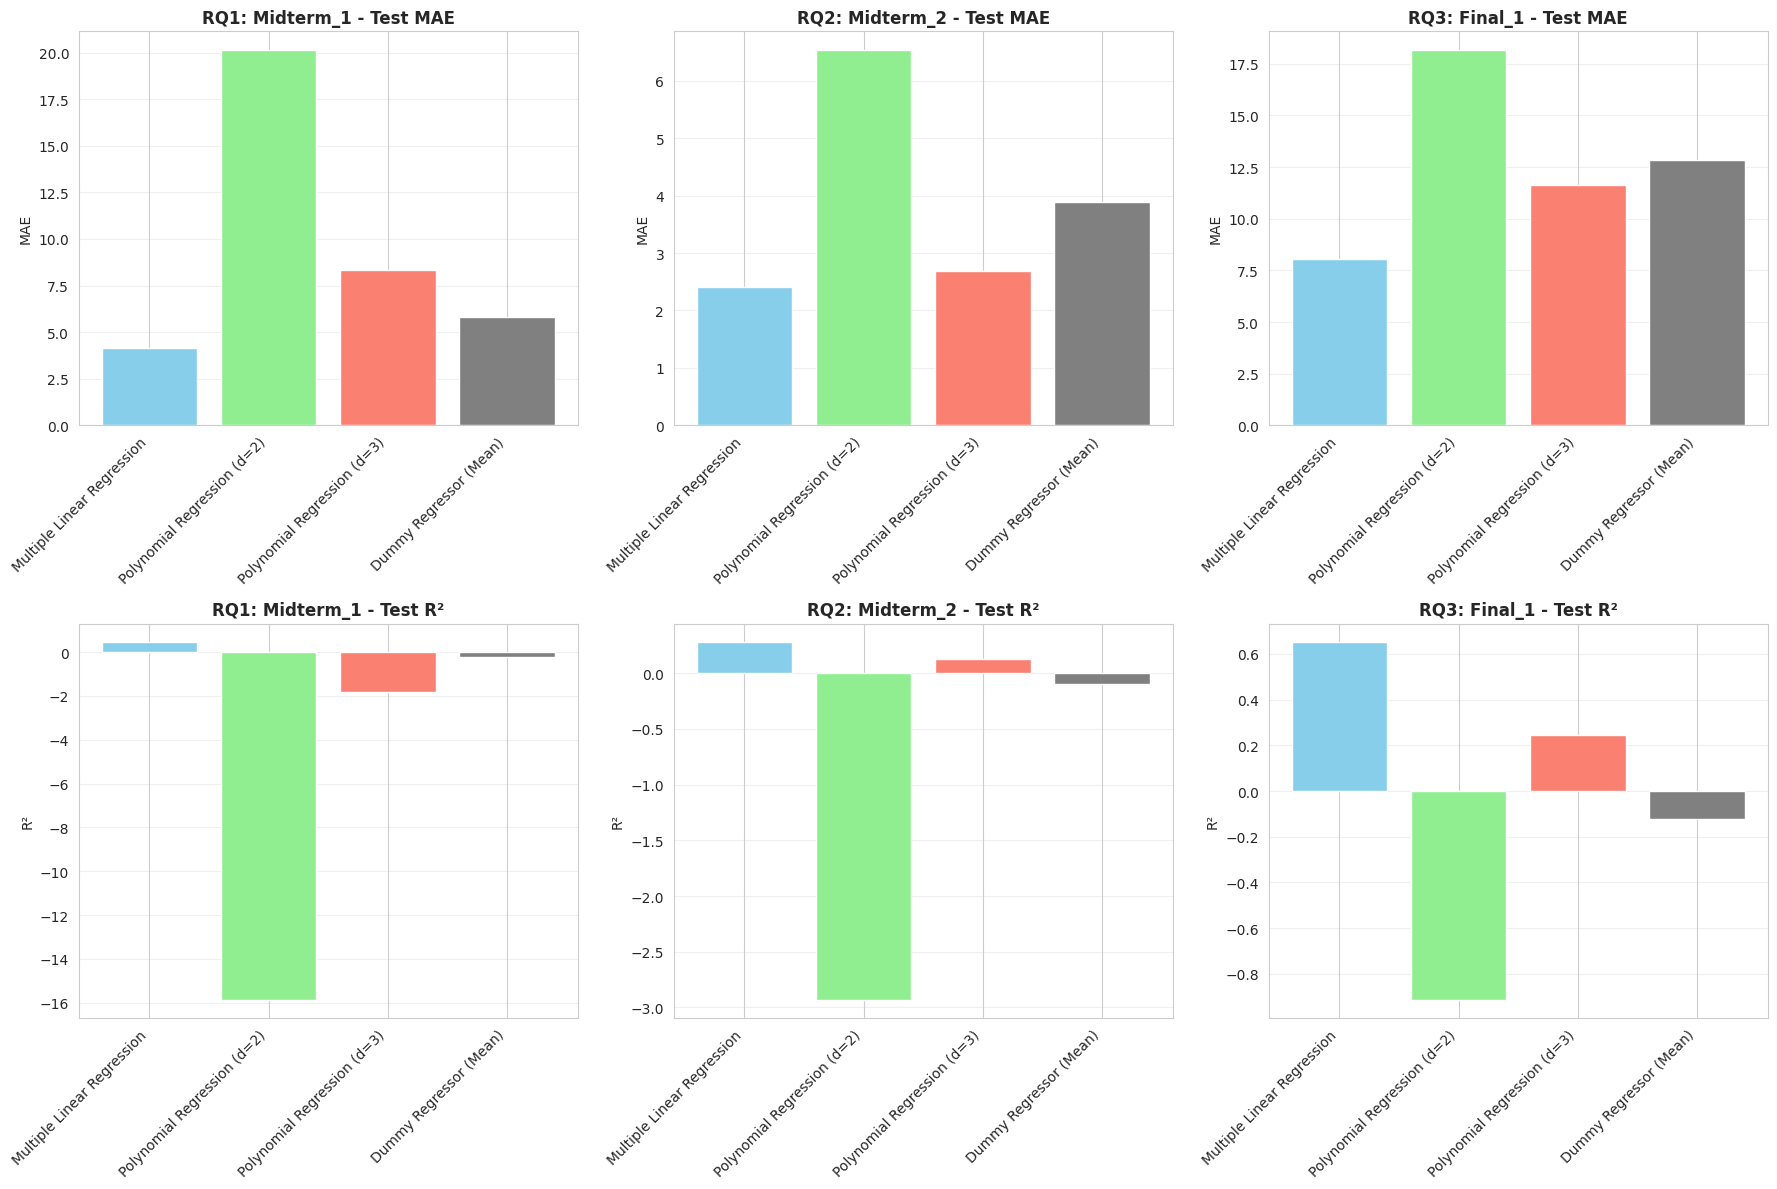

✓ Model comparison visualization completed!


In [22]:
# Cell 21: Visualization - Model Comparison Across All RQs

print("=" * 80)
print("MODEL COMPARISON VISUALIZATION")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# RQ1 - MAE Comparison
models_rq1 = [r['Model'] for r in results_rq1]
test_mae_rq1 = [r['Test_MAE'] for r in results_rq1]
axes[0, 0].bar(range(len(models_rq1)), test_mae_rq1, color=['skyblue', 'lightgreen', 'salmon', 'gray'])
axes[0, 0].set_xticks(range(len(models_rq1)))
axes[0, 0].set_xticklabels(models_rq1, rotation=45, ha='right')
axes[0, 0].set_title(f'RQ1: {rq1_target} - Test MAE', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(axis='y', alpha=0.3)

# RQ1 - R² Comparison
test_r2_rq1 = [r['Test_R2'] for r in results_rq1]
axes[1, 0].bar(range(len(models_rq1)), test_r2_rq1, color=['skyblue', 'lightgreen', 'salmon', 'gray'])
axes[1, 0].set_xticks(range(len(models_rq1)))
axes[1, 0].set_xticklabels(models_rq1, rotation=45, ha='right')
axes[1, 0].set_title(f'RQ1: {rq1_target} - Test R²', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('R²')
axes[1, 0].grid(axis='y', alpha=0.3)

# RQ2
if rq2_target:
    models_rq2 = [r['Model'] for r in results_rq2]
    test_mae_rq2 = [r['Test_MAE'] for r in results_rq2]
    axes[0, 1].bar(range(len(models_rq2)), test_mae_rq2, color=['skyblue', 'lightgreen', 'salmon', 'gray'])
    axes[0, 1].set_xticks(range(len(models_rq2)))
    axes[0, 1].set_xticklabels(models_rq2, rotation=45, ha='right')
    axes[0, 1].set_title(f'RQ2: {rq2_target} - Test MAE', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].grid(axis='y', alpha=0.3)

    test_r2_rq2 = [r['Test_R2'] for r in results_rq2]
    axes[1, 1].bar(range(len(models_rq2)), test_r2_rq2, color=['skyblue', 'lightgreen', 'salmon', 'gray'])
    axes[1, 1].set_xticks(range(len(models_rq2)))
    axes[1, 1].set_xticklabels(models_rq2, rotation=45, ha='right')
    axes[1, 1].set_title(f'RQ2: {rq2_target} - Test R²', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('R²')
    axes[1, 1].grid(axis='y', alpha=0.3)

# RQ3
if rq3_target:
    models_rq3 = [r['Model'] for r in results_rq3]
    test_mae_rq3 = [r['Test_MAE'] for r in results_rq3]
    axes[0, 2].bar(range(len(models_rq3)), test_mae_rq3, color=['skyblue', 'lightgreen', 'salmon', 'gray'])
    axes[0, 2].set_xticks(range(len(models_rq3)))
    axes[0, 2].set_xticklabels(models_rq3, rotation=45, ha='right')
    axes[0, 2].set_title(f'RQ3: {rq3_target} - Test MAE', fontsize=12, fontweight='bold')
    axes[0, 2].set_ylabel('MAE')
    axes[0, 2].grid(axis='y', alpha=0.3)

    test_r2_rq3 = [r['Test_R2'] for r in results_rq3]
    axes[1, 2].bar(range(len(models_rq3)), test_r2_rq3, color=['skyblue', 'lightgreen', 'salmon', 'gray'])
    axes[1, 2].set_xticks(range(len(models_rq3)))
    axes[1, 2].set_xticklabels(models_rq3, rotation=45, ha='right')
    axes[1, 2].set_title(f'RQ3: {rq3_target} - Test R²', fontsize=12, fontweight='bold')
    axes[1, 2].set_ylabel('R²')
    axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Model comparison visualization completed!")

In [23]:
# Cell 22: Save Preprocessed Dataset

print("=" * 80)
print("SAVING PREPROCESSED DATASET")
print("=" * 80)

# Save the preprocessed dataset
output_file = "preprocessed_dataset.csv"
df_features.to_csv(output_file, index=False)

print(f"✓ Preprocessed dataset saved to: {output_file}")
print(f"  Shape: {df_features.shape}")
print(f"  Columns: {len(df_features.columns)}")
print(f"\nSample of saved data:")
print(df_features.head())

# Also save summary statistics
summary_file = "dataset_summary.txt"
with open(summary_file, 'w') as f:
    f.write("PREPROCESSED DATASET SUMMARY\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Total Students: {len(df_features)}\n")
    f.write(f"Total Features: {len(df_features.columns)}\n\n")
    f.write("Columns:\n")
    for col in df_features.columns:
        f.write(f"  - {col}\n")
    f.write("\n")
    f.write("Descriptive Statistics:\n")
    f.write(df_features.describe().to_string())

print(f"\n✓ Summary statistics saved to: {summary_file}")

SAVING PREPROCESSED DATASET
✓ Preprocessed dataset saved to: preprocessed_dataset.csv
  Shape: (272, 45)
  Columns: 45

Sample of saved data:
   Sr.# Sheet  Assignment_1  Assignment_2  Assignment_3  Assignment_4  \
0  None     1           3.0           3.0           3.0           3.0   
1  None     1         130.0          70.0          90.0          50.0   
2  None     1           0.0           0.0           0.0           0.0   
3  None     1          80.5          60.5          73.5          40.5   
4  None     1          72.5          68.0          39.0          35.0   

   Assignment_5  Assignment_6  Quiz_1  Quiz_2  ...  Assignment_Sum  Quiz_Mean  \
0           3.0           3.0     2.0     2.0  ...            18.0     2.0000   
1         120.0          90.0     5.0    15.0  ...           550.0     8.6250   
2           0.0           0.0     0.0     0.0  ...             0.0     0.0000   
3          59.0          70.5     3.5     5.0  ...           384.5     4.0000   
4          80.